# Source of Data
The Movie Database (TMDB): https://www.themoviedb.org/

Our goal will be to

- Determine where to save our results and in what file format.
- Decide what subset of movies to retrieve (based on Years).
- Develop code to make API calls based on our existing IMDB IDs with the INNER Loop
- Organize output by year into separate .json files using an OUTER LOOP
- BEFORE the Loops
    - Designate a folder to save your information
    - Define the years you wish to retrieve
    - Define any custom functions you will use
- Create an OUTER loop for each year with a progress bar using tqdm_notebook
    1. Define a JSON_FILE filename to save the results in progress.
        - Check if the file exists.
            - if no:
                - Create the empty JSON file with with open that just contains the key "imdb_id"
            - if yes:
                - Do nothing.
    2. Define/filter the movie IDs you want to retrieve (that belongs to the year being retrieved)
    3. Check for and remove any previously downloaded movie id's to prevent duplicate API calls.
        - Load in any existing/previous results with pd.read_json
            - Check to see if any of the movie_ids to get are already in the JSON file.
            - Filter out only movies that are missing from JSON file to use in the loop.
- Create an INNER loop to make API calls for each id in the YEAR specified in the outer loop. For each id:
    - Load up results thus far from JSON file as a list.
    - Extract current ID from API and extract dictionary of results
    - Append the new results to the list from the JSON file
    - Save the updated JSON file back to disk
- After the inner loop, save the final results for that year as a csv.gz file with the year in the filename.
    - Then, the outer loop repeats for the remaining years.

# Import Libraries

In [78]:
import pandas as pd
import os, time,json
import tmdbsimple as tmdb 
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt

# API Credentials

In [2]:
with open('C://Users//sheha//.secret/tmdb_api.json', 'r') as f:
    login = json.load(f)
    
## Display the keys of the loaded dict
login.keys()

dict_keys(['api-key'])

In [3]:
tmdb.API_KEY =  login['api-key']

# Designate a folder

In [4]:
FOLDER = "Data/"
os.makedirs(FOLDER, exist_ok= True)
os.listdir(FOLDER)

['final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'title_akas_chunk_001.csv.gz',
 'title_akas_chunk_002.csv.gz',
 'title_akas_chunk_003.csv.gz',
 'title_akas_chunk_004.csv.gz',
 'title_akas_chunk_005.csv.gz',
 'title_akas_chunk_006.csv.gz',
 'title_akas_chunk_007.csv.gz',
 'title_akas_chunk_008.csv.gz',
 'title_akas_chunk_009.csv.gz',
 'title_akas_chunk_010.csv.gz',
 'title_akas_chunk_011.csv.gz',
 'title_akas_chunk_012.csv.gz',
 'title_akas_chunk_013.csv.gz',
 'title_akas_chunk_014.csv.gz',
 'title_akas_chunk_015.csv.gz',
 'title_akas_chunk_016.csv.gz',
 'title_akas_chunk_017.csv.gz',
 'title_akas_chunk_018.csv.gz',
 'title_akas_chunk_019.csv.gz',
 'title_akas_chunk_020.csv.gz',
 'title_akas_chunk_021.csv.gz',
 'title_akas_chunk_022.csv.gz',
 'title_akas_chunk_023.csv.gz',
 'title_akas_chunk_024.csv.gz',
 'title_akas_chunk_025.csv.gz',
 'title_akas_chunk_026.csv.gz',
 'title_akas_chunk_027.csv.gz',
 'title_akas_chunk_028.csv.gz',
 'title_akas_chunk_029.csv.gz',
 'title_

# Define Functions

## Movie Rating Function

In [5]:
def get_movie_with_rating(movie_id):
    """Adapted  from source =  https://github.com/celiao/tmdbsimple"""
    # Get the object for the current id
    movie = tmdb.Movies(movie_id)
    
    # save the .info .releases dictionaries 
    info = movie.info()
    
    releases = movie.releases()
    # loop through countries in releases
    for c in releases['countries']:
        if c['iso_3166_1'] == 'US':
            ## save a "certification" key in the info dict with the certification
            info['certification'] = c['certification']
    return info

## Append records to json file

In [6]:
def write_json(new_data, filename): 
    """Appends a list of records (new_data) to a json file (filename). 
    Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""  
    
    with open(filename, 'r+') as file:
        #First we load existing data into a dict.
        file_data = json.load(file)
        ## use extend and or append
        if (type(new_data)==list) & (type(file_data)==list):
            file_data.extend(new_data)
        else:
            file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        #convert back to json
        json.dump(file_data, file)

# Load in the Title Basics data

In [7]:
basics = pd.read_csv("Data/title_basics.csv.gz")

# Create Required Lists for the Loop

In [8]:
# Define a list of the Years to Extract from the API
YEARS_TO_GET = [2000,2001]

In [9]:
# define error list
errors = [ ]

# Testing the "get_movie_with_rating" function

In [10]:
test_ids = ["tt0848228", "tt0332280"]
results = []

for movie_id in test_ids:
    
    try:
        movie_info = get_movie_with_rating(movie_id)
        results.append(movie_info)
        
    except Exception as e:
        errors.append([movie_id, e])
    
    
pd.DataFrame(results)

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,False,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,"{'id': 86311, 'name': 'The Avengers Collection...",220000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",https://www.marvel.com/movies/the-avengers,24428,tt0848228,en,The Avengers,...,1518815515,143,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Some assembly required.,The Avengers,False,7.700,27909,PG-13
1,False,/qom1SZSENdmHFNZBXbtJAU0WTlC.jpg,None,29000000,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",http://www.newline.com/properties/notebookthe....,11036,tt0332280,en,The Notebook,...,115603229,123,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Behind every great love is a great story.,The Notebook,False,7.881,9980,PG-13


In [11]:
print(f"- Number of errors: {len(errors)}")
errors

- Number of errors: 0


[]

# Set up Progress Bar

In [12]:
# OUTER loop
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
    #Defining the JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    #check if file exists
    file_exists = os.path.isfile(JSON_FILE)
    # If it does not exist: create it
    if file_exists == False:
        # save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)
    
    #Saving new year as the current df
    df = basics.loc[ basics['startYear']==YEAR].copy()
    
    # saving movie ids to list
    movie_ids = df['tconst'].copy()
    
    # Load existing data from json into a dataframe called "previous_df"
    previous_df = pd.read_json(JSON_FILE)
    
    # filter out any ids that are already in the JSON_FILE
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]

# INNER Loop
    for movie_id in tqdm_notebook(movie_ids_to_get,
                                  desc=f'Movies from {YEAR}',
                                  position=1,
                                  leave=True):
        try:
            # Retrieve then data for the movie id
            temp = get_movie_with_rating(movie_id)  
            # Append/extend results to existing file using a pre-made function
            write_json(temp,JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)
            
        except Exception as e:
            errors.append([movie_id, e])

    
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz",
                         compression="gzip", index=False)



YEARS:   0%|          | 0/2 [00:00<?, ?it/s]

Movies from 2000:   0%|          | 0/206 [00:00<?, ?it/s]

Movies from 2001:   0%|          | 0/240 [00:00<?, ?it/s]

# Exploratory Data Analysis

In [13]:
df_2000 = pd.read_csv("Data/final_tmdb_data_2000.csv.gz")
df_2000.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,NaN
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
4,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.108,2059.0,PG


In [14]:
df_2001 = pd.read_csv("Data/final_tmdb_data_2001.csv.gz")
df_2001.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0035423,0.0,/hfeiSfWYujh6MKhtGTXyK3DD4nN.jpg,NaN,48000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 14, ...",NaN,11232.0,en,Kate & Leopold,...,76019048.0,118.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"If they lived in the same century, they'd be p...",Kate & Leopold,0.0,6.321,1162.0,PG-13
2,tt0114447,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",NaN,151007.0,en,The Silent Force,...,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They left him for dead... They should have fin...,The Silent Force,0.0,5.000,3.0,NaN
3,tt0118589,0.0,/9NZAirJahVilTiDNCHLFcdkwkiy.jpg,NaN,22000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,10696.0,en,Glitter,...,5271666.0,104.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"In music she found her dream, her love, herself.",Glitter,0.0,4.600,118.0,PG-13
4,tt0118652,0.0,/mWxJEFRMvkG4UItYJkRDMgWQ08Y.jpg,NaN,1000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",NaN,17140.0,en,The Attic Expeditions,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,His search for peace of mind... will leave his...,The Attic Expeditions,0.0,5.100,28.0,R


In [16]:
## Combine years 2000 and 2001 into a single dataframe
df_combined = pd.concat([df_2000, df_2001], ignore_index= True)
display (df_combined.head(), df_combined.tail())

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,NaN
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
4,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.108,2059.0,PG


,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
2504,tt7797670,0.0,NaN,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,956214.0,en,Edmund Kemper Part 2: La Mort C'est La Vie,...,0.0,91.0,[],Released,NaN,Edmund Kemper Part 2: La Mort C'est La Vie,0.0,0.0,0.0,NaN
2505,tt7797790,0.0,NaN,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,956219.0,en,Edmund Kemper Part 3: La mort sévit,...,0.0,72.0,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,NaN,Edmund Kemper Part 3: La mort sévit,0.0,0.0,0.0,NaN
2506,tt8665056,0.0,NaN,NaN,0.0,"[{'id': 37, 'name': 'Western'}]",http://skeletoncreekproductions.com/p-movie-br...,885436.0,en,Guns Along The Bravo,...,0.0,85.0,[],Released,Evil came to the Southwest until three blazing...,Guns Along The Bravo,0.0,0.0,0.0,NaN
2507,tt8795764,0.0,NaN,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",https://www.utahwolf.com/films/coming-soon-new...,871624.0,en,New Breed,...,0.0,57.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,New Breed,0.0,0.0,0.0,NR
2508,tt9071078,0.0,NaN,NaN,0.0,"[{'id': 28, 'name': 'Action'}]",http://www.hkcinemagic.com/en/movie.asp?id=6627,201706.0,cn,致命密函,...,0.0,90.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,NaN,Chinese Heroes,0.0,3.0,2.0,NaN


1. How many movies had at least some valid financial information (values > 0 for budget OR revenue)?
    - Please exclude any movies with 0's for budget AND revenue from the remaining visualizations.


In [35]:
df_filter1 = df_combined[(df_combined['budget']>0) | (df_combined['revenue']>0)]
print(f'The number of movies which has atleast valid financial information: {df_filter1.shape[0]}')

The number of movies which has atleast valid financial information: 627


In [40]:
df_filter2 = df_filter1[(df_filter1['budget']>0) & (df_filter1['revenue']>0)]
df_filter2.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
4,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.108,2059.0,PG
11,tt0120467,0.0,/knok3mNReKqPTplnnqz7E4dd7mD.jpg,NaN,120000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",NaN,19085.0,en,Vulgar,...,14904.0,87.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Everyone loves a clown... some more than others.,Vulgar,0.0,5.400,42.0,R
13,tt0120630,0.0,/t7aJ7hqsMLEoqBJk7yAXxcAVvcz.jpg,"{'id': 718551, 'name': 'Chicken Run Collection...",45000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",NaN,7443.0,en,Chicken Run,...,224834564.0,84.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,This ain't no chick flick. It's poultry in mot...,Chicken Run,0.0,6.733,4198.0,G
16,tt0120753,0.0,/3vUkQpnwbsFEQlMh9EORpvKJfpo.jpg,NaN,8000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,318.0,en,The Million Dollar Hotel,...,105983.0,122.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Everyone has something to hide.,The Million Dollar Hotel,0.0,5.904,260.0,R
17,tt0120755,0.0,/24DZfupDlhXeTchmcOkoGRhP5Vg.jpg,"{'id': 87359, 'name': 'Mission: Impossible Col...",125000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",NaN,955.0,en,Mission: Impossible II,...,546388105.0,123.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Expect the impossible again.,Mission: Impossible II,0.0,6.109,5571.0,PG-13


2. How many movies are there in each of the certification categories (G/PG/PG-13/R)?


In [41]:
df_filter2['certification'].value_counts()

R        142
PG-13    117
PG        29
G         13
NR         6
Name: certification, dtype: int64

3. What is the average revenue per certification category?


In [82]:
df_cer_rev= df_filter2.groupby('certification')['revenue'].mean().sort_values(ascending = False)

In [83]:
df_cer_rev

certification
PG       1.346373e+08
G        1.332169e+08
PG-13    1.110740e+08
R        5.294547e+07
NR       2.382332e+07
Name: revenue, dtype: float64

Text(0.5, 1.0, 'Average Revenue Vs Certification')

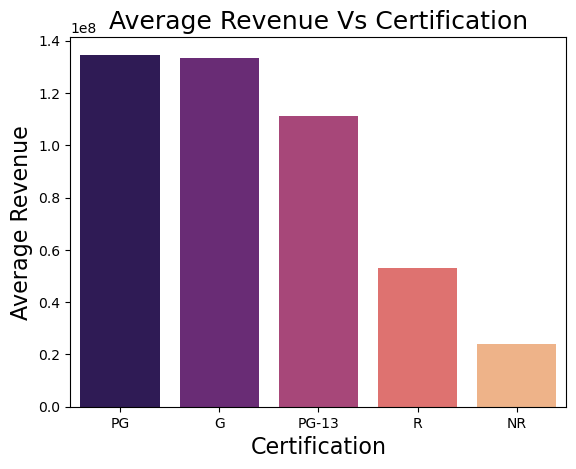

In [86]:
sns.barplot(x=df_cer_rev.index, y = df_cer_rev.values, palette='magma')
plt.ylabel('Average Revenue', fontsize=16)
plt.xlabel('Certification',fontsize=16 )
plt.title('Average Revenue Vs Certification', fontsize=18)

4. What is the average budget per certification category?

In [87]:
df_cer_bud= df_filter2.groupby('certification')['budget'].mean().sort_values(ascending = False)

In [89]:
df_cer_bud

certification
PG       5.374138e+07
PG-13    4.680682e+07
G        4.400000e+07
R        2.706348e+07
NR       1.478333e+07
Name: budget, dtype: float64

Text(0.5, 1.0, 'Average Budget Vs Certification')

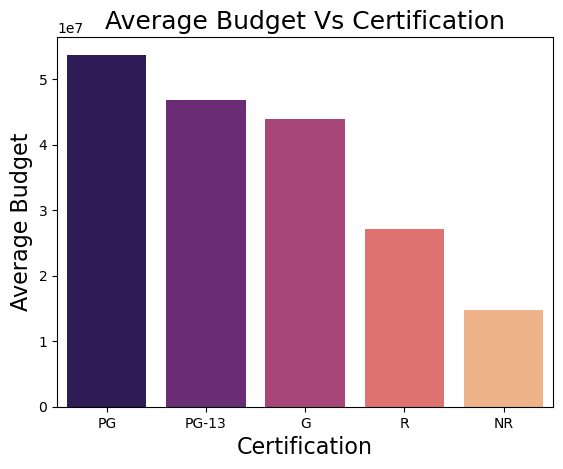

In [88]:
sns.barplot(x=df_cer_bud.index, y = df_cer_bud.values, palette='magma')
plt.ylabel('Average Budget', fontsize=16)
plt.xlabel('Certification',fontsize=16 )
plt.title('Average Budget Vs Certification', fontsize=18)